In [1]:
#install packages
!pip install fancyimpute
!pip install cloudmesh-installer
!pip install cloudmesh-common
!pip install cloudmesh_client
!pip install cloudmesh-cmd5



/bin/bash: pip install cloudmesh-installer: command not found
/bin/bash: pip install cloudmesh-common: command not found


In [2]:
# Import Packages
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import re
from fancyimpute import KNN
from sklearn import preprocessing
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.metrics import homogeneity_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA
import sklearn.linear_model
from sklearn.impute import SimpleImputer
from cloudmesh.common.StopWatch import StopWatch
import time



In [8]:
# Upload Dataset
from google.colab import files
proteomedata = files.upload()

Saving CancerProteomes.csv to CancerProteomes.csv


In [9]:
# Upload Dataset
from google.colab import files
pam50data = files.upload()

Saving PAM50 Proteins.csv to PAM50 Proteins (1).csv


In [10]:
# Upload Dataset
from google.colab import files
clinicaldata = files.upload()

Saving ClinicalDataBreastCancer.csv to ClinicalDataBreastCancer.csv


In [11]:
df_proteome = pd.read_csv('CancerProteomes.csv', index_col = 0 )

In [12]:
PAM50 = pd.read_csv('PAM50 Proteins.csv', header = 0)


In [13]:
clinical = pd.read_csv('ClinicalDataBreastCancer.csv', index_col = 0)


In [14]:
df_proteome

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,AN-A04A.05TCGA,BH-A0AV.05TCGA,C8-A12T.06TCGA,A8-A06Z.07TCGA,A2-A0CM.07TCGA,BH-A18U.08TCGA,A2-A0EQ.08TCGA,AR-A0U4.09TCGA,AO-A0J9.10TCGA,AR-A1AP.11TCGA,AN-A0FK.11TCGA,AO-A0J6.11TCGA,A7-A13F.12TCGA,BH-A0E1.12TCGA,A7-A0CE.13TCGA,A2-A0YC.13TCGA,AO-A0JC.14TCGA,A8-A08Z.14TCGA,AR-A0TX.14TCGA,A8-A076.15TCGA,AO-A126.15TCGA,BH-A0C1.16TCGA,A2-A0EY.16TCGA,AR-A1AW.17TCGA,AR-A1AV.17TCGA,C8-A135.17TCGA,A2-A0EV.18TCGA,AN-A0AM.18TCGA,...,AO-A0JJ.20TCGA,AO-A0JE.21TCGA,AN-A0AJ.21TCGA,A7-A0CJ.22TCGA,AO-A12F.22TCGA,A8-A079.23TCGA,A2-A0T3.24TCGA,A2-A0YD.24TCGA,AR-A0TR.25TCGA,AO-A03O.25TCGA,AO-A12E.26TCGA,A8-A06N.26TCGA,A2-A0YG.27TCGA,BH-A18N.27TCGA,AN-A0AL.28TCGA,A2-A0T6.29TCGA,E2-A158.29TCGA,E2-A15A.29TCGA,AO-A0JM.30TCGA,C8-A12V.30TCGA,A2-A0D2.31TCGA,C8-A12U.31TCGA,AR-A1AS.31TCGA,A8-A09G.32TCGA,C8-A131.32TCGA,C8-A134.32TCGA,A2-A0YF.33TCGA,BH-A0DD.33TCGA,BH-A0E9.33TCGA,AR-A0TT.34TCGA,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,0.384588,0.350536,-0.204918,-0.496409,0.683404,-0.265030,-0.912670,-0.033221,0.020007,0.461088,0.973564,0.831132,1.279185,0.762044,-1.123173,0.818824,-0.307267,0.568895,-0.583429,1.873982,0.195877,-0.518366,1.174881,0.578309,-0.759823,1.120502,0.452986,1.501967,...,0.757188,0.559777,-0.428181,-1.00124,-1.947792,1.048959,0.583713,0.063779,-1.101675,1.053225,0.264859,0.238547,-0.078202,1.101261,0.323663,0.793976,-1.086529,2.180123,1.395247,0.673905,0.107491,-0.481550,1.222507,-1.523343,2.707250,0.140182,0.311319,-0.692316,1.466665,-0.511421,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,0.371393,0.367405,-0.162418,-0.498509,0.694424,-0.251642,-0.927979,-0.030216,0.011955,0.461088,0.977476,0.856540,1.275167,0.762044,-1.123173,0.814877,-0.307267,0.568895,-0.572549,1.870383,0.195877,-0.510002,1.183209,0.582213,-0.759823,1.137618,0.472590,1.510348,...,0.780871,0.563407,-0.406378,-1.00462,-1.952718,1.052257,0.580623,0.093336,-1.108783,1.055948,0.275711,0.249818,-0.068058,1.101261,0.326973,0.818182,-1.095492,2.180123,1.408922,0.688718,0.104164,-0.477890,1.218974,-1.512646,2.733832,0.126054,0.296177,-0.659469,1.482283,-0.526067,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,0.371393,0.367405,-0.166668,-0.496409,0.698098,-0.251642,-0.927979,-0.027212,0.011955,0.461088,0.977476,0.856540,1.275167,0.766384,-1.116861,0.814877,-0.307267,0.568895,-0.567109,1.870383,0.195877,-0.507214,1.183209,0.578309,-0.749114,1.137618,0.472590,1.501967,...,0.774104,0.559777,-0.406378,-1.00462,-1.955180,1.052257,0.580623,0.084469,-1.108783,1.055948,0.275711,0.244183,-0.071439,1.097767,0.326973,0.814724,-1.095492,2.180123,1.412341,0.688718,0.107491,-0.481550,1.222507,-1.509972,2.737629,0.133118,0.296177,-0.664161,1.474474,-0.526067,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,0.377990,0.360657,-0.183668,-0.492209,0.687077,-0.251642,-0.931806,-0.030216,0.003904,0.461088,0.969652,0.836778,1.279185,0.757704,-1.129486,0.799090,-0.307267,0.568895,-0.583429,1.859587,0.218935,-0.518366,1.174881,0.590021,-0.735727,1.137618,0.458587,1.501967,...,0.763955

In [16]:
clinical

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,Positive,Stage IV,No_Conversion,followup,DECEASED,240,240.0,1,240,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1555,1555.0,1,1555,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,Negative,Stage IIIC,No_Conversion,followup,LIVING,133,NaN,0,133,Basal-like,0,-13,5,5,Basal,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-BH-A0C7,FEMALE,48,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1305,NaN,0,1305,Luminal B,-3,0,4,4,LumA/B,5,4,1,3
TCGA-BH-A0DD,MALE,58,Positive,Positive,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1393,NaN,0,1393,Luminal B,-3,-6,4,4,LumA/B,3,4,1,3
TCGA-C8-A12U,FEMALE,46,Positive,Positive,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IB,Stage IIB,enrollment,LIVING,0,NaN,0,0,Luminal B,-5,-2,5,4,Basal,5,4,1,1


In [15]:
PAM50

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160
...,...,...,...,...
95,FOXC1,NP_001444,Homo sapiens,forkhead box C1
96,GRB7,NP_001025173,Homo sapiens,growth factor receptor-bound protein 7
97,GRB7,NP_005301,Homo sapiens,growth factor receptor-bound protein 7
98,MELK,NP_055606,Homo sapiens,maternal embryonic leucine zipper kinase


In [17]:
#Drop unused columns in proteome dataset
proteomes = df_proteome.drop(['gene_symbol','gene_name'], axis=1)
proteomes

,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,AN-A04A.05TCGA,BH-A0AV.05TCGA,C8-A12T.06TCGA,A8-A06Z.07TCGA,A2-A0CM.07TCGA,BH-A18U.08TCGA,A2-A0EQ.08TCGA,AR-A0U4.09TCGA,AO-A0J9.10TCGA,AR-A1AP.11TCGA,AN-A0FK.11TCGA,AO-A0J6.11TCGA,A7-A13F.12TCGA,BH-A0E1.12TCGA,A7-A0CE.13TCGA,A2-A0YC.13TCGA,AO-A0JC.14TCGA,A8-A08Z.14TCGA,AR-A0TX.14TCGA,A8-A076.15TCGA,AO-A126.15TCGA,BH-A0C1.16TCGA,A2-A0EY.16TCGA,AR-A1AW.17TCGA,AR-A1AV.17TCGA,C8-A135.17TCGA,A2-A0EV.18TCGA,AN-A0AM.18TCGA,D8-A142.18TCGA,AN-A0FL.19TCGA,...,AO-A0JJ.20TCGA,AO-A0JE.21TCGA,AN-A0AJ.21TCGA,A7-A0CJ.22TCGA,AO-A12F.22TCGA,A8-A079.23TCGA,A2-A0T3.24TCGA,A2-A0YD.24TCGA,AR-A0TR.25TCGA,AO-A03O.25TCGA,AO-A12E.26TCGA,A8-A06N.26TCGA,A2-A0YG.27TCGA,BH-A18N.27TCGA,AN-A0AL.28TCGA,A2-A0T6.29TCGA,E2-A158.29TCGA,E2-A15A.29TCGA,AO-A0JM.30TCGA,C8-A12V.30TCGA,A2-A0D2.31TCGA,C8-A12U.31TCGA,AR-A1AS.31TCGA,A8-A09G.32TCGA,C8-A131.32TCGA,C8-A134.32TCGA,A2-A0YF.33TCGA,BH-A0DD.33TCGA,BH-A0E9.33TCGA,AR-A0TT.34TCGA,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NP_958782,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,1.185108,1.100688,0.384588,0.350536,-0.204918,-0.496409,0.683404,-0.265030,-0.912670,-0.033221,0.020007,0.461088,0.973564,0.831132,1.279185,0.762044,-1.123173,0.818824,-0.307267,0.568895,-0.583429,1.873982,0.195877,-0.518366,1.174881,0.578309,-0.759823,1.120502,0.452986,1.501967,0.538596,2.455138,...,0.757188,0.559777,-0.428181,-1.00124,-1.947792,1.048959,0.583713,0.063779,-1.101675,1.053225,0.264859,0.238547,-0.078202,1.101261,0.323663,0.793976,-1.086529,2.180123,1.395247,0.673905,0.107491,-0.481550,1.222507,-1.523343,2.707250,0.140182,0.311319,-0.692316,1.466665,-0.511421,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,1.192612,1.100688,0.371393,0.367405,-0.162418,-0.498509,0.694424,-0.251642,-0.927979,-0.030216,0.011955,0.461088,0.977476,0.856540,1.275167,0.762044,-1.123173,0.814877,-0.307267,0.568895,-0.572549,1.870383,0.195877,-0.510002,1.183209,0.582213,-0.759823,1.137618,0.472590,1.510348,0.542211,2.480137,...,0.780871,0.563407,-0.406378,-1.00462,-1.952718,1.052257,0.580623,0.093336,-1.108783,1.055948,0.275711,0.249818,-0.068058,1.101261,0.326973,0.818182,-1.095492,2.180123,1.408922,0.688718,0.104164,-0.477890,1.218974,-1.512646,2.733832,0.126054,0.296177,-0.659469,1.482283,-0.526067,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,1.188860,1.100688,0.371393,0.367405,-0.166668,-0.496409,0.698098,-0.251642,-0.927979,-0.027212,0.011955,0.461088,0.977476,0.856540,1.275167,0.766384,-1.116861,0.814877,-0.307267,0.568895,-0.567109,1.870383,0.195877,-0.507214,1.183209,0.578309,-0.749114,1.137618,0.472590,1.501967,0.542211,2.480137,...,0.774104,0.559777,-0.406378,-1.00462,-1.955180,1.052257,0.580623,0.084469,-1.108783,1.055948,0.275711,0.244183,-0.071439,1.097767,0.326973,0.814724,-1.095492,2.180123,1.412341,0.688718,0.107491,-0.481550,1.222507,-1.509972,2.737629,0.133118,0.296177,-0.664161,1.474474,-0.526067,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,1.185108,1.100688,0.377990,0.360657,-0.183668,-0.492209,0.687077,-0.251642,-0.931806,-0.030216,0.003904,0.461088,0.969652,0.836778,1.279185,0.757704,-1.129486,0.799090,-0.307267,0.568895,-0.583429,1.859587,0.218935,-0.518366,1.174881,0.590021,-0.735727,1.137618,0.458587,1.501967,0.534981,2.461956,...,0.763955,0.541627,-0.

In [18]:
#Rename the "TGCA-ID" in the proteome dataset
proteomes.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)

In [19]:
# Transpose into row to align with the clinical dataset
proteomes = proteomes.transpose()
proteomes

RefSeq_accession_number,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_061841,NP_001014979,NP_848561,NP_000331,NP_690591,XP_003960234,NP_000237,NP_057387,NP_004187,NP_065087,NP_004953,NP_001034806,NP_065119,NP_110392,NP_620138,NP_062558,NP_001005163,NP_665813,NP_005279,NP_998761,YP_003024032,NP_001165887,NP_001010893,NP_872303,NP_000871,NP_690872,NP_683762,NP_060064,NP_699174,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494
TCGA-AO-A12D,1.096131,1.111370,1.111370,1.107561,1.115180,1.107561,1.111370,1.111370,-1.517390,0.482754,0.261785,0.924690,-0.580180,-0.012520,-0.187771,2.044771,-0.065857,-0.351592,0.318932,0.318932,0.970408,1.526638,1.526638,1.111370,-0.507794,0.082725,0.539901,2.101918,0.802777,1.183757,-0.450647,1.035174,0.962788,1.035174,0.962788,1.111370,0.661814,2.098108,1.385676,-0.911632,...,NaN,0.025578,-0.100145,NaN,NaN,-2.881298,NaN,-2.058382,NaN,NaN,NaN,1.275192,0.787538,NaN,NaN,0.825636,1.454252,0.840875,NaN,0.139872,NaN,0.932310,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.231655,NaN,NaN,NaN,-0.340163,NaN,NaN,NaN,NaN,-0.633517,12.666488
TCGA-C8-A131,2.609943,2.650422,2.650422,2.646374,2.646374,2.646374,2.650422,2.650422,3.909313,-1.045294,-0.037371,1.399627,-0.134520,0.756014,0.173119,1.593925,-0.875283,-1.021006,-0.438111,-0.438111,1.642499,2.925678,2.925678,-0.616218,1.391531,2.524937,2.184915,0.513141,1.294382,-0.838852,0.768157,1.391531,1.699170,1.233663,2.018952,2.018952,0.169071,0.513141,0.614338,-0.725511,...,NaN,1.691074,0.007156,NaN,NaN,1.079844,NaN,-5.890607,NaN,NaN,NaN,1.314621,0.662912,NaN,NaN,0.136688,1.002934,1.468441,NaN,-0.446207,NaN,1.229616,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.279550,NaN,NaN,NaN,3.451902,NaN,NaN,NaN,NaN,4.840325,0.140736
TCGA-AO-A12B,-0.659828,-0.648742,-0.654285,-0.632113,-0.640428,-0.654285,-0.648742,-0.648742,-0.618256,1.222003,1.019685,-1.230752,0.781338,-1.092178,-1.785046,-1.266781,-2.281140,0.016412,0.088470,0.088470,-0.906489,-2.383685,-2.383685,-3.467331,-2.799406,-2.466829,-2.641432,-0.673685,-1.943020,-7.763116,-2.480686,-2.799406,-2.480686,-2.799406,-2.480686,-2.403085,-1.721303,-0.662600,-0.260736,0.116185,...,NaN,-2.863150,-0.593313,NaN,NaN,-1.308353,NaN,-6.413408,NaN,NaN,NaN,0.529134,-1.541157,NaN,NaN,1.887156,-4.900183,-0.837202,NaN,-2.228482,NaN,0.756395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.462290,NaN,NaN,NaN,-1.718531,NaN,NaN,NaN,NaN,-1.965192,-2.854835
TCGA-BH-A18Q,0.195341,0.215413,0.215413,0.205377,0.215413,0.215413,0.215413,0.215413,-1.035760,-0.517226,-0.724639,-0.085671,-0.306467,0.737293,2.041991,1.028341,1.868032,-0.881872,0.780782,0.787473,0.018035,-0.758093,-0.758093,-3.865953,-3.865953,1.924903,1.965048,-0.821655,2.098863,1.101939,-2.397330,-1.567676,-0.597515,-1.567676,-1.567676,-1.340190,0.185305,-0.821655,-1.410443,-7.569291,...,-20.331922,-3.210258,-2.598053,-3.936206,NaN,NaN,-10.680496,-12.028685,3.360072,NaN,-2.159808,-3.414326,NaN,NaN,NaN,2.895064,NaN,NaN,-13.547488,-4.896331,-4.708989,NaN,NaN,-2.865684,0.723911,NaN,NaN,NaN,0.583405,-11.864761,0.048144,NaN,-0.881872,2.527072,-8.111243,-16.029761,-2.046065,-1.778435,NaN,-3.069752
TCGA-C8-A130,-0.494060,-0.503899,-0.500619,-0.510459,-0.503899,-0.503899,-0.500619,-0.500619,-1.845366,-0.405503,-0.703971,-0.785968,-0.917163,-1.133634,-0.520299,0.109436,-0.976200,-1.517379,-0.608855,-0.621974,0.847407,0.555498,0.555498,-0.448141,-0.510459,-0.464541,-0.225110,0.230791,-0.592456,-0.149673,-0.398943,-0.126714,-1.399303,-0.448141,-0.398943,-0.398943,-0.077516,0.234071,-0.349745,0.345587,...,3.425384,-0.041438,0.598137,-0.494060,NaN,NaN,0.460382,-3.678812,1.962562,NaN,1.742811,-1.6190

In [20]:
#Drop entries in the clinical dataset thate are not in the proteome dataset
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in proteomes.index],:]

In [21]:
clinical

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,No_Conversion,enrollment,DECEASED,1692,1692.0,1,1692,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-A7-A0CE,FEMALE,57,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,309,NaN,0,309,Basal-like,0,-13,5,5,Basal,1,2,2,2
TCGA-D8-A142,FEMALE,74,Negative,Negative,Negative,T3,T_Other,N0,Negative,M0,Negative,Stage IIB,Stage IIB,followup,LIVING,425,NaN,0,425,Basal-like,0,-13,3,5,X,1,2,2,2
TCGA-AO-A0J6,FEMALE,61,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,775,NaN,0,775,Basal-like,-12,-13,2,5,Basal,1,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-AR-A1AV,MALE,68,Positive,Positive,Negative,T2,T_Other,N1,Positive,M0,Negative,Stage II,Stage IIB,enrollment,LIVING,1295,NaN,0,1295,Luminal B,-5,-2,7,3,LumA/B,3,4,4,5
TCGA-BH-A0C7,FEMALE,48,Positive,Negative,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1305,NaN,0,1305,Luminal B,-3,0,4,4,LumA/B,5,4,1,3
TCGA-BH-A0DD,MALE,58,Positive,Positive,Positive,T2,T_Other,N1,Positive,M0,Negative,Stage IIB,Stage IIB,enrollment,LIVING,1393,NaN,0,1393,Luminal B,-3,-6,4,4,LumA/B,3,4,1,3


In [22]:
#Merge the first and third datasets
merged_data = proteomes.merge(clinical,left_index=True,right_index=True)
merged_data

,NP_958782,NP_958785,NP_958786,NP_000436,NP_958781,NP_958780,NP_958783,NP_958784,NP_112598,NP_001611,NP_076965,NP_001367,NP_036222,NP_001138241,NP_001714,NP_002464,NP_001073936,NP_061198,NP_001074248,NP_001074419,NP_056009,NP_036355,NP_001155291,NP_002462,NP_000248,NP_036467,NP_004989,NP_001243024,NP_149043,NP_067047,NP_002461,NP_060003,NP_003793,NP_060004,NP_005954,NP_002463,NP_689914,NP_001242941,NP_060227,NP_055796,...,NP_001164045,NP_001193600,NP_061134,NP_932347,NP_003593,NP_997203,NP_001191293,NP_775791,NP_004065,NP_068752,NP_219494,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,Metastasis-Coded,AJCC Stage,Converted Stage,Survival Data Form,Vital Status,Days to Date of Last Contact,Days to date of Death,OS event,OS Time,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
TCGA-A2-A0CM,0.683404,0.694424,0.698098,0.687077,0.687077,0.698098,0.698098,0.698098,-2.652150,-0.984373,-0.547225,0.654015,-0.672124,-1.436216,-0.150485,-0.308446,0.136049,-1.590504,-0.716207,-0.705186,-1.223152,-1.910100,-1.902753,-1.054170,-1.054170,0.598913,0.867079,-0.701512,1.124226,0.161764,-0.337834,-0.664777,-0.374569,-0.374569,-0.374569,-0.110076,-0.069667,-0.712533,NaN,-0.172526,...,NaN,NaN,NaN,1.153614,NaN,NaN,NaN,NaN,NaN,NaN,NaN,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,DECEASED,754,754.0,1,754,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-A2-A0D2,0.107491,0.104164,0.107491,0.097512,0.104164,0.104164,0.104164,0.104164,-0.880454,-1.512473,-1.406028,0.077553,0.493355,-0.594383,-0.002281,0.932442,-1.595633,-1.213096,-0.295005,-0.295005,0.436806,-0.361534,-0.408103,1.018928,1.161964,1.218513,2.236396,0.689613,1.391487,-3.162374,1.161964,1.305000,1.018928,1.161964,1.161964,1.018928,-0.677543,0.686287,-4.070485,-1.203116,...,-5.158223,0.919136,-1.648856,0.832649,NaN,-8.324969,-4.679219,NaN,-1.106650,NaN,-6.941181,FEMALE,45,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,Negative,Stage IIB,Stage IIA,followup,LIVING,1027,NaN,0,1027,Basal-like,-12,-13,4,5,Basal,3,2,2,2
TCGA-A2-A0EQ,-0.912670,-0.927979,-0.927979,-0.931806,-0.927979,-0.927979,-0.927979,-0.927979,-3.071151,-2.278943,-2.236845,-0.598849,-1.471426,-1.750804,-2.056971,-1.215011,1.272601,-1.414020,-1.215011,-1.306861,-0.537615,0.974087,0.931989,-1.842654,-1.525005,0.461257,-0.610330,-1.984257,2.382458,0.671747,-1.287726,-1.525005,-1.452291,-1.486734,-1.486734,-1.452291,2.401593,-1.991911,NaN,-0.120462,...,-0.970077,-0.801685,NaN,NaN,3.802310,-6.373934,-1.123160,NaN,NaN,NaN,NaN,FEMALE,64,Negative,Negative,Positive,T2,T_Other,N0,Negative,M0,Negative,Stage IIA,Stage IIA,followup,LIVING,2426,NaN,0,2426,HER2-enriched,-5,-2,5,4,Basal,4,4,1,1
TCGA-A2-A0EV,0.452986,0.472590,0.472590,0.458587,0.472590,0.472590,0.472590,0.472590,-0.742871,1.811277,1.956909,-0.247164,-1.022931,-0.109935,0.024494,0.002089,-1.272184,-0.448808,4.158181,4.107770,1.223151,-0.485215,-0.474013,-2.669684,-2.145972,0.819865,0.881478,-0.247164,1.802876,-0.165947,-3.123381,-2.669684,-2.260796,-2.669684,-2.669684,-2.669684,-0.616844,-0.247164,-0.151944,-1.532640,...,NaN,-4.966177,-1.471027,NaN,-0.474013,-12.278546,-10.337729,-0.653251,NaN,NaN,NaN,FEMALE,80,Positive,Positive,Negative,T1,T1,N0,Negative,M0,Negative,Stage IA,Stage I,followup,LIVING,968,NaN,0,968,Luminal A,-4,0,4,2,ReacI,3,3,3,4
TCGA-A2-A0EX,1.185108,1.192612,1.188860,1.185108,1.200116,1.188860,1.188860,1.192612,1.046289,2.138081,1.732880,0.187113,-0.687070,0.093317,0.734885,1.151341,0.273406,1.725376,1.035034,1.046289,3.586299,0.138339,0.138339,1.515272,1.759143,0.239639,1.372701,2.828423,0.588562,-0.068013,1.275153,2.081803,2.093059,1.995510,1.995510,1.995510,0.903719,2.809664,-1.707576,0.070806,...,NaN,1.451490,-2.018981,0.877456,NaN,NaN,-6.101005,NaN,-1.726336,

In [23]:
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
merged_numerical= merged_data.loc[:,[x for x in merged_data.columns if bool(re.search("NP_|XP_",x)) == True]]

In [24]:
#Add the "PAM50 mRNA" column from the second dataset into the merged dataset

pam50_data = merged_numerical.iloc[:,merged_numerical.columns.isin(PAM50['RefSeqProteinID'])]
pam50_data

,NP_057427,NP_002408,NP_000415,NP_000413,NP_000517,NP_004439,NP_005219,NP_058519,NP_058518,NP_001116539,NP_061155,NP_001035932,NP_077006,NP_000917,NP_065178,NP_006836,NP_006614,NP_001784,NP_006092,NP_001153651,NP_001159403,NP_000116,NP_004314,NP_060601,NP_005931,NP_003003,NP_113611,NP_002002,NP_004487,NP_008950,NP_114172,NP_001062,NP_001444,NP_057547,NP_054895,NP_001246,NP_055606,NP_036451,NP_000624,NP_569082,NP_001159,NP_001229,NP_002458
TCGA-A2-A0CM,2.160157,2.623021,4.768355,0.639321,4.933663,-4.419112,-0.271711,-6.013418,-6.013418,-6.318320,2.277710,-4.029719,-4.029719,-6.509343,1.906685,2.215260,-1.601524,1.631171,2.013217,-6.395464,0.584219,-4.937078,-0.433346,3.126292,-1.182743,0.286664,0.980958,1.509945,-4.433806,2.549550,2.733226,0.896468,1.576068,-1.292949,3.541400,3.177722,NaN,-1.792547,NaN,NaN,2.516489,2.556897,NaN
TCGA-A2-A0D2,2.249702,3.576941,2.169868,2.968207,0.543251,-5.421010,-1.206443,-5.297932,-5.277974,-5.311238,2.934943,-5.567372,-5.567372,-5.287953,1.198555,3.264258,2.449287,2.332862,3.606879,-7.124134,-0.853843,-4.153646,-2.417258,-0.604362,2.545753,7.053044,2.921637,3.743262,-6.269245,2.376105,2.781928,6.836827,2.898353,-3.694601,2.495856,2.722053,0.373604,-1.342826,-4.183584,-2.889608,3.487128,NaN,-0.714133
TCGA-A2-A0EQ,-0.020957,1.884936,-7.407249,-7.675146,-5.187535,-2.795601,7.158672,-9.114133,-8.762041,-9.573385,-0.859091,-1.241800,-1.241800,-7.047502,1.961478,0.863101,1.842838,-0.369223,0.266075,-3.055843,-0.836128,-6.308873,-0.686872,0.162743,-2.791774,-5.554936,0.047930,3.388984,0.063239,0.545453,-0.273546,1.460128,NaN,-1.410193,0.702364,-1.402538,NaN,NaN,1.934688,NaN,0.798041,2.003576,NaN
TCGA-A2-A0EV,-1.364604,-2.246793,-3.750716,-3.882344,-2.252395,-3.252209,-1.574649,-2.190781,-2.871327,-2.190781,-4.632905,-2.608071,-2.608071,-1.266583,1.158737,-2.039549,-1.160160,-1.216172,-1.185366,0.466989,-1.924724,0.649028,-0.488016,-6.134027,0.534203,1.080321,-0.709263,-1.199369,-1.723081,-2.179579,-3.311022,0.139319,0.733046,0.018893,-1.574649,-4.515280,NaN,NaN,2.049328,NaN,-0.266769,-3.201798,-7.724769
TCGA-A2-A0EX,-2.506723,-2.953194,-0.803378,-2.315378,-0.098028,-1.643795,-1.212331,4.186597,3.976493,3.942726,-2.521730,0.427232,0.415977,1.545287,1.725376,-1.812629,-2.476708,-0.923438,-1.966455,-2.037740,-1.973959,-2.409174,0.115828,-0.882167,0.419729,1.031282,-1.666306,-0.083021,-0.281869,-3.752341,-3.317125,-2.769353,NaN,-0.822137,-2.938187,-3.395914,-1.827636,0.082061,0.044543,-2.079011,-3.046991,2.554537,-0.443199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-C8-A138,-0.409316,0.739026,0.943825,1.415596,1.806910,-0.504402,-2.625542,-5.284283,-4.907597,-5.309883,1.272968,0.329426,0.329426,-3.207028,0.523254,-1.634458,-1.440629,1.232739,0.014912,-1.510115,-0.668973,-3.693427,0.219712,0.567140,0.735368,-3.748284,-0.690916,-0.105774,0.618340,-0.178916,-0.610459,-0.153316,2.461538,-0.248402,-0.295945,-2.307371,4.641193,-1.799029,NaN,NaN,-2.076972,-0.851830,1.554568
TCGA-D8-A142,-0.415696,-1.232627,-2.823113,1.724231,0.668726,-3.130366,-0.462687,-6.427009,-6.195666,-6.427009,-1.529036,-5.530553,-5.530553,-6.394476,0.813316,-1.778453,1.496502,2.721899,0.065065,-5.244989,-0.592818,-3.065300,-1.619404,-3.867773,0.621735,0.397621,-0.086754,7.757232,-3.990674,-0.726563,-1.467585,-1.456741,2.049557,-2.320664,-1.232627,-1.438667,NaN,NaN,-0.910915,NaN,-0.075910,-0.101213,-7.659635
TCGA-E2-A154,-2.742664,-3.307172,-5.903908,-5.218972,-4.650701,-3.894260,-3.284592,2.861017,3.098110,2.981445,-2.061491,-0.710436,-0.710436,4.415295,0.226647,-2.622236,-4.184041,-1.214730,-2.012567,6.989451,-1.579778,1.735765,3.327677,-1.820635,-0.243776,-0.879788,-4.522746,1.223944,1.235234,-1.463113,-3.860390,-0.620115,-6.615188,-0.202379,-2.772771,-6.268957,1.340609,1.826086,NaN,NaN,0.395999,-3.962001,-7.804418
TCGA-E2-A158,-0.781777,-1.588474,-3.732945,0.701651,0.213150,-2.531862,-0.277591,-4.456

In [25]:
#Change the new name of the new data
pam50data = KNN(k=3).fit_transform(pam50_data)


Imputing row 1/80 with 4 missing, elapsed time: 0.007


In [26]:
#Load data
pam50data

array([[ 2.16015744,  2.62302061,  4.76835465, ...,  2.51648861,
         2.5568973 , -1.798724  ],
       [ 2.24970172,  3.57694103,  2.16986778, ...,  3.48712784,
         0.24596977, -0.71413343],
       [-0.0209573 ,  1.88493566, -7.40724933, ...,  0.79804088,
         2.00357559, -0.60721473],
       ...,
       [-2.74266425, -3.30717211, -5.90390825, ...,  0.39599944,
        -3.96200122, -7.80441803],
       [-0.78177666, -1.58847422, -3.73294524, ...,  0.13832362,
         3.24050703, -2.09041937],
       [ 0.22965842, -0.44137307, -1.18398126, ..., -0.4345125 ,
         1.85802818, -4.31546156]])

##Perform KMeans

In [27]:
#Prepare data
scaler = StandardScaler().fit(pam50data)
pam50data = scaler.transform(pam50data)
np.set_printoptions(precision=3)
print(pam50data[0:5,:])


[[ 1.915e+00  1.787e+00  2.369e+00  9.568e-01  2.682e+00 -8.578e-01
   6.850e-01 -1.013e+00 -1.010e+00 -1.054e+00  1.318e+00 -1.537e+00
  -1.531e+00 -1.206e+00  1.562e+00  1.863e+00 -4.580e-01  9.945e-01
   1.367e+00 -1.187e+00  8.662e-01 -1.204e+00 -1.459e-01  2.179e+00
  -4.303e-01  1.997e-01  6.071e-01  4.986e-01 -1.728e+00  1.557e+00
   1.614e+00  5.386e-01  5.812e-01 -3.561e-01  2.334e+00  1.894e+00
   6.732e-01 -7.138e-01 -8.014e-01 -1.857e-02  1.790e+00  1.050e+00
   2.037e-01]
 [ 1.987e+00  2.311e+00  1.507e+00  1.730e+00  8.918e-01 -1.169e+00
   2.537e-01 -8.251e-01 -8.157e-01 -7.961e-01  1.637e+00 -2.233e+00
  -2.225e+00 -8.745e-01  8.146e-01  2.665e+00  1.258e+00  1.380e+00
   2.363e+00 -1.372e+00 -1.407e-01 -9.308e-01 -1.357e+00 -6.253e-03
   1.564e+00  2.251e+00  1.797e+00  1.423e+00 -2.569e+00  1.467e+00
   1.641e+00  3.759e+00  1.277e+00 -1.613e+00  1.697e+00  1.674e+00
   2.395e-01 -4.903e-01 -2.081e+00 -2.045e+00  2.402e+00 -2.895e-01
   6.261e-01]
 [ 1.775e-01  1.381e

In [33]:
print(pam50data[0:5,:])
n_clusters = [2,3,4,5,6,7,8,10,20,79]

def compare_k_means(k_list,data):
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(init='k-means++', n_clusters=k, n_init=10).fit(data)
        #clusterer = KMeans(n_clusters=k, n_jobs=4)
        #clusterer.fit(data)
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(silhouette_score(data, clusterer.labels_), 4)))

        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(homogeneity_score(merged_data['PAM50 mRNA'], clusterer.labels_),4)))
        print("Ajusted Rand score for k == %s: %s" % (
        k, round(adjusted_rand_score(merged_data['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")


[[ 1.915e+00  1.787e+00  2.369e+00  9.568e-01  2.682e+00 -8.578e-01
   6.850e-01 -1.013e+00 -1.010e+00 -1.054e+00  1.318e+00 -1.537e+00
  -1.531e+00 -1.206e+00  1.562e+00  1.863e+00 -4.580e-01  9.945e-01
   1.367e+00 -1.187e+00  8.662e-01 -1.204e+00 -1.459e-01  2.179e+00
  -4.303e-01  1.997e-01  6.071e-01  4.986e-01 -1.728e+00  1.557e+00
   1.614e+00  5.386e-01  5.812e-01 -3.561e-01  2.334e+00  1.894e+00
   6.732e-01 -7.138e-01 -8.014e-01 -1.857e-02  1.790e+00  1.050e+00
   2.037e-01]
 [ 1.987e+00  2.311e+00  1.507e+00  1.730e+00  8.918e-01 -1.169e+00
   2.537e-01 -8.251e-01 -8.157e-01 -7.961e-01  1.637e+00 -2.233e+00
  -2.225e+00 -8.745e-01  8.146e-01  2.665e+00  1.258e+00  1.380e+00
   2.363e+00 -1.372e+00 -1.407e-01 -9.308e-01 -1.357e+00 -6.253e-03
   1.564e+00  2.251e+00  1.797e+00  1.423e+00 -2.569e+00  1.467e+00
   1.641e+00  3.759e+00  1.277e+00 -1.613e+00  1.697e+00  1.674e+00
   2.395e-01 -4.903e-01 -2.081e+00 -2.045e+00  2.402e+00 -2.895e-01
   6.261e-01]
 [ 1.775e-01  1.381e

In [29]:
#Impute missing numbers
imputer = SimpleImputer()
merged_numerical_random = merged_data.iloc[:,np.random.choice(range(merged_data.shape[1]),43)]
imputer_rnd = imputer.fit(merged_numerical_random)
merged_numerical_random = imputer_rnd.transform(merged_numerical_random)


In [30]:
n_clusters = [2,3,4,5,6,7,8,10,20,79]

In [31]:
#Check different numbers of clusters for the PAM50 proteins 

compare_k_means(n_clusters,pam50data)
#clusterer = KMeans(n_clusters=3, n_jobs=4)
#km = KMeans(init='k-means++', n_clusters=3, n_init=10).fit(pam50data)
#clusterer.fit(pam50data)


Silhouette Coefficient for k == 2: 0.1556
Homogeneity score for k == 2: 0.1793
Ajusted Rand score for k == 2: 0.1977
------------------------
Silhouette Coefficient for k == 3: 0.143
Homogeneity score for k == 3: 0.4635
Ajusted Rand score for k == 3: 0.4515
------------------------
Silhouette Coefficient for k == 4: 0.1393
Homogeneity score for k == 4: 0.4749
Ajusted Rand score for k == 4: 0.4355
------------------------
Silhouette Coefficient for k == 5: 0.1193
Homogeneity score for k == 5: 0.4766
Ajusted Rand score for k == 5: 0.3442
------------------------
Silhouette Coefficient for k == 6: 0.117
Homogeneity score for k == 6: 0.5474
Ajusted Rand score for k == 6: 0.4402
------------------------
Silhouette Coefficient for k == 7: 0.1009
Homogeneity score for k == 7: 0.5353
Ajusted Rand score for k == 7: 0.3702
------------------------
Silhouette Coefficient for k == 8: 0.0968
Homogeneity score for k == 8: 0.5617
Ajusted Rand score for k == 8: 0.2953
------------------------
Silhouet

In [34]:
#Use random proteins in the merged data for comparison with the above pam50data

compare_k_means(n_clusters,merged_numerical_random)


Silhouette Coefficient for k == 2: 0.1734
Homogeneity score for k == 2: 0.0196
Ajusted Rand score for k == 2: 0.0143
------------------------
Silhouette Coefficient for k == 3: 0.1021
Homogeneity score for k == 3: 0.1398
Ajusted Rand score for k == 3: 0.1107
------------------------
Silhouette Coefficient for k == 4: 0.0934
Homogeneity score for k == 4: 0.1796
Ajusted Rand score for k == 4: 0.1134
------------------------
Silhouette Coefficient for k == 5: 0.0879
Homogeneity score for k == 5: 0.174
Ajusted Rand score for k == 5: 0.1012
------------------------
Silhouette Coefficient for k == 6: 0.0899
Homogeneity score for k == 6: 0.218
Ajusted Rand score for k == 6: 0.0819
------------------------
Silhouette Coefficient for k == 7: 0.0737
Homogeneity score for k == 7: 0.2572
Ajusted Rand score for k == 7: 0.1212
------------------------
Silhouette Coefficient for k == 8: 0.0619
Homogeneity score for k == 8: 0.1993
Ajusted Rand score for k == 8: 0.0411
------------------------
Silhouet

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

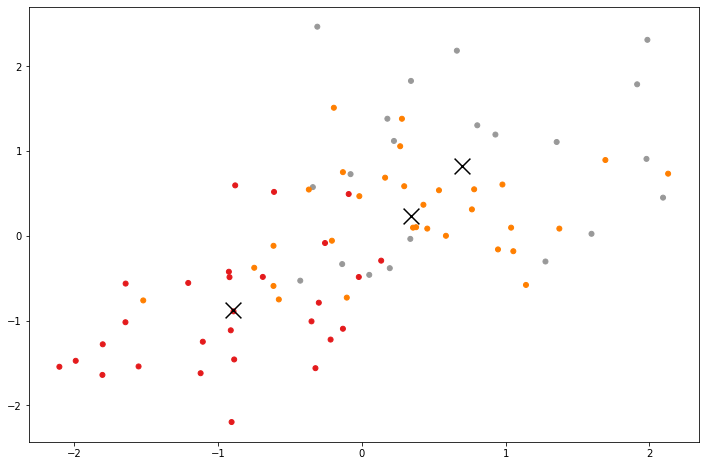

In [35]:
## Visualize data using k==3
#clusterer_final = KMeans(n_clusters=3, n_jobs=4)
#clusterer_final = clusterer_final.fit(pam50data)
clusterer_final = KMeans(init='k-means++', n_clusters=3, n_init=10).fit(pam50data)
processed_p50_plot = pd.DataFrame(pam50data)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)
fig = plt.figure(figsize=(12,8))

plt.scatter(pam50data[:,0], pam50data[:,1], c=clusterer_final.labels_, cmap="Set1_r", s=25)
plt.scatter(clusterer_final.cluster_centers_[:,0] ,clusterer_final.cluster_centers_[:,1], color='black', marker="x", s=250)
plt.savefig('new.png')

files.download('new.png')
plt.show()

In [36]:
for n_component in range(1, 16, 2):
    pca = PCA(n_components=n_component)
    StopWatch.start(f'parallel {n_component}')
    reduced_data = pca.fit_transform(pam50data)
    print('\nComponents: {}'.format(n_component))
    print('% of Variance Explained: {}'.format(sum(pca.explained_variance_ratio_)))
    compare_k_means(n_clusters, reduced_data)
    StopWatch.stop(f'parallel {n_component}')
    StopWatch.benchmark()




Components: 1
% of Variance Explained: 0.302212500765331
Silhouette Coefficient for k == 2: 0.5217
Homogeneity score for k == 2: 0.1751
Ajusted Rand score for k == 2: 0.1953
------------------------
Silhouette Coefficient for k == 3: 0.5985
Homogeneity score for k == 3: 0.3105
Ajusted Rand score for k == 3: 0.2757
------------------------
Silhouette Coefficient for k == 4: 0.538
Homogeneity score for k == 4: 0.3006
Ajusted Rand score for k == 4: 0.1927
------------------------
Silhouette Coefficient for k == 5: 0.5425
Homogeneity score for k == 5: 0.2931
Ajusted Rand score for k == 5: 0.1635
------------------------
Silhouette Coefficient for k == 6: 0.533
Homogeneity score for k == 6: 0.3395
Ajusted Rand score for k == 6: 0.1708
------------------------
Silhouette Coefficient for k == 7: 0.5341
Homogeneity score for k == 7: 0.3853
Ajusted Rand score for k == 7: 0.1997
------------------------
Silhouette Coefficient for k == 8: 0.5514
Homogeneity score for k == 8: 0.3764
Ajusted Rand 

In [37]:
pca=PCA(n_components=5)
ProteomicsX_pca=pca.fit(pam50data)
ProteomicsX_pca2=ProteomicsX_pca.transform(pam50data)
print(pca.explained_variance_ratio_)


[0.302 0.11  0.086 0.067 0.046]


In [38]:
#Using a cluster of 4
n_clusters = 4
KMeansModel=KMeans(n_clusters=n_clusters, init='k-means++')
KMeanData=ProteomicsX_pca2
KMeansModel.fit(KMeanData)
labels=KMeansModel.labels_
centroids=KMeansModel.cluster_centers_
print("LABELS",labels)
print("----------------------------")
print("Centroids",centroids)


LABELS [2 2 2 1 3 1 0 2 0 3 3 1 3 0 2 2 0 0 3 0 1 0 3 1 3 0 2 1 3 2 0 1 3 3 1 1 2
 0 3 3 3 1 1 0 2 3 1 0 1 2 3 3 0 3 1 3 2 0 0 1 0 3 3 2 1 2 0 0 2 1 0 2 2 2
 1 1 1 3 1 0]
----------------------------
Centroids [[ 0.386  2.55   1.134  0.509 -0.05 ]
 [-0.364 -2.078  1.006  0.298 -0.64 ]
 [ 5.038 -0.576 -1.001 -0.545  0.531]
 [-4.322  0.144 -1.228 -0.316  0.232]]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

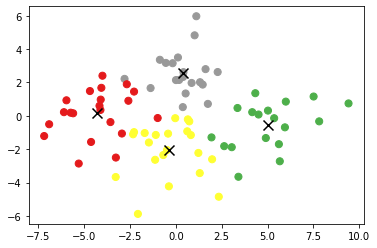

In [39]:
plt.scatter(KMeanData[:,0], KMeanData[:,1], c=KMeansModel.labels_, cmap="Set1_r", s=50)
plt.scatter(KMeansModel.cluster_centers_[:,0] ,KMeansModel.cluster_centers_[:,1], color='black', marker="x", s=100)
plt.savefig('test.png')

files.download('test.png')
plt.show()
